In [242]:
import pandas as pd
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [243]:
def get_id(df, teamname):
    return df[df['country']==teamname]['country_id'].reset_index(drop=True)[0] 

In [244]:
def ret_victory_home(row):
    if row['goal1'] > row['goal2']:
        return 'победа'
    elif row['goal1'] < row['goal2']:
        return 'поражение'
    else:
        return 'ничья'
    
def ret_victory_guest(row):
    if row['goal1'] > row['goal2']:
        return 'поражение'
    elif row['goal1'] < row['goal2']:
        return 'победа'
    else:
        return 'ничья'

In [245]:
def get_home_game_points(row):
    if row['goal1'] > row['goal2']:
        return 3
    elif row['goal1'] < row['goal2']:
        return 0
    else:
        return 1

def get_guest_game_pints(row):
    if row['goal1'] > row['goal2']:
        return 0
    elif row['goal1'] < row['goal2']:
        return 3
    else:
        return 1

In [246]:
def get_group_table(df, group_name):   
    group_games = games_df[games_df['group'] == group_name]
    group_teams = pd.concat([group_games['team1'], group_games['team2']]).unique()
    group_table = []
    for team in group_teams:
        # Считаем таблицу "домашних" игр
        team_home_games = group_games[group_games['team1']==team]
        team_home_games['points'] = team_home_games.apply(get_home_game_points,axis=1)
        # Считаем таблицу "гостевых" игр
        team_guest_games = group_games[group_games['team2']==team]
        team_guest_games['points'] = team_guest_games.apply(get_guest_game_pints,axis=1)
        # Объединяем общую таблицу
        team_games= pd.concat([team_home_games, team_guest_games],axis=0)
        team_games['points'] = team_games['points'].astype('int')
        team_games_count = len(team_games)
        # Суммарные характеристики
        team_points = team_games['points'].sum()
        team_goals_scored = team_home_games['goal1'].sum() + team_guest_games['goal2'].sum()
        team_goals_missed = team_home_games['goal2'].sum() + team_guest_games['goal1'].sum()
        group_table.append([team, team_points, team_games_count, team_goals_scored, team_goals_missed])
    
    group_table = pd.DataFrame(group_table, columns=['team', 'points', 'games', 'goals_scored', 'goals_missed'])
    group_table['goals_diff'] = group_table['goals_scored'] - group_table['goals_missed']
    group_table = group_table.sort_values(by='points',ascending=False)
    try:
        group_table.index = [1, 2, 3, 4]
    except:
        group_table = group_table.reset_index(drop=True)
    return group_table

In [247]:
def get_lineup(lteam):
    lteam_id = get_id(countries, lteam)

    lplayers = players[players['country'] == lteam] # Общий состав страны
    lplayers_array = players['name']
    llineup = lineups_df[lineups_df['country_id']==lteam_id].pivot_table(index='name', values='total', aggfunc=['sum', 'count']) # Выходы
    llineup.columns = ['time', 'games']
    lteam_players = lplayers.merge(llineup, on='name', how='left')
    # Голы
    try:
        lgoals = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'].isin(['гол','пенальти']))]
         .pivot_table(index='name', values='event', aggfunc='count'))
        lgoals.columns = ['goals']
        lteam_players = lteam_players.merge(lgoals, on='name', how='left')
    except ValueError:
        lteam_players['goals'] = 0
    # Ассисты
    try:
        lassist = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'пас')]
         .pivot_table(index='name', values='event', aggfunc='count'))
        lassist.columns = ['assist']
        lteam_players = lteam_players.merge(lassist, on='name', how='left')
    except ValueError:
        lteam_players['assist'] = 0
    # Желтые карточки
    try:
        lyellows = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'желтая карточка')]
         .pivot_table(index='name', values='event', aggfunc='count'))
        lyellows.columns = ['yellows']
        lteam_players = lteam_players.merge(lyellows, on='name', how='left')
    except ValueError:
        lteam_players['yellows'] = 0
    # Красные карточки
    try:
        lreds = (events_df[(events_df['country_id']==lteam_id) & (events_df['event'] == 'красная карточка')]
         .pivot_table(index='name', values='event', aggfunc='count'))
        lreds.columns = ['reds']
        lreds
        lteam_players = lteam_players.merge(lreds, on='name', how='left')
    except:
        lteam_players['reds'] = 0
    lteam_players = lteam_players.drop(['country_id', 'country'], axis=1)
    lteam_players = lteam_players.fillna(0)
    lteam_players[['age', 'time','games', 'goals', 'assist', 'yellows', 'reds']] = lteam_players[['age', 'time', 'games', 'goals', 'assist', 'yellows', 'reds']].astype('int')
    lteam_players.index = ['']*len(lteam_players) # Скрывает индекс
    return lteam_players.sort_values(by='num')

Загружаем таблицы

In [249]:
countries = pd.read_csv('countries.csv')
players = pd.read_csv('players.csv')
events_df = pd.read_csv('events.csv')
lineups_df = pd.read_csv('lineups.csv')
games_df = pd.read_csv('games.csv')
old_games = pd.read_csv('old_games.csv')

Правим таблицы

In [250]:
countries.columns = ['country_id', 'country']
players.columns = ['num', 'name', 'team', 'birthdate', 'pos', 'country_id']
lineups_df['total'] = lineups_df['out'] - lineups_df['in']
players = players.merge(countries, on='country_id')
players['birthdate'] = pd.to_datetime(players['birthdate'], format='%d-%m-%Y')
players['age'] = ((dt.datetime.now() - players['birthdate']).dt.days / 365).apply(np.floor)
old_games['date'] =  pd.to_datetime(old_games['date'], format='%d-%m-%Y')

## Предварительная статистика

In [251]:
(players.
 pivot_table(index='team', values='num', aggfunc='count').
 sort_values(by='num', ascending=False).
 head(10)
)

,num
team,
Интер Милан,13
Манчестер Сити,13
Пари Сен-Жермен,12
Реал Мадрид,12
РБ Лейпциг,11
Барселона,11
Арсенал,10
Славия (Прага),10
Байер 04,10


### Возраст игроков

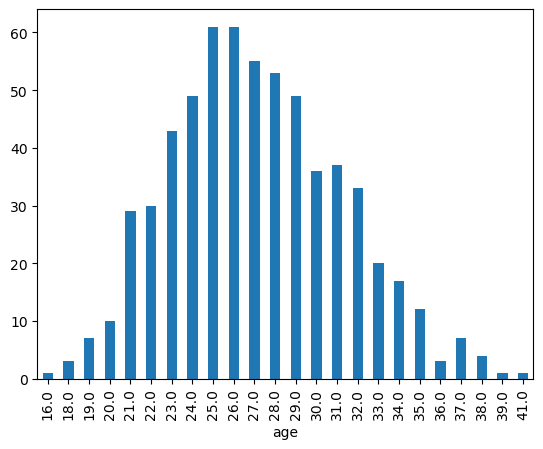

In [252]:
players.groupby('age')['num'].count().plot(kind='bar');

In [253]:
players['age'].describe()

count    622.000000
mean      27.135048
std        4.130842
min       16.000000
25%       24.000000
50%       27.000000
75%       30.000000
max       41.000000
Name: age, dtype: float64

Самые возрастные игроки

In [254]:
players.sort_values(by='birthdate').head(5)

,num,name,team,birthdate,pos,country_id,country,age
574,3,Пепе,Порту,1983-02-26,защ,23,Португалия,41.0
589,7,Криштиану Роналду,Ан-Наср (Эр-Рияд),1985-02-05,нап,23,Португалия,39.0
143,10,Лука Модрич,Реал Мадрид,1985-09-09,поз,6,Хорватия,38.0
113,22,Хесус Навас,Севилья,1985-11-21,защ,5,Испания,38.0
544,1,Георгий Лория,Динамо Тбилиси,1986-01-27,врт,22,Грузия,38.0


Самые молодые игроки

In [255]:
players.sort_values(by='birthdate', ascending=False).head(5)

,num,name,team,birthdate,pos,country_id,country,age
127,19,Ламин Ямаль,Барселона,2007-07-13,нап,5,Испания,16.0
405,18,Варрен Заир-Эмри,Пари Сен-Жермен,2006-03-08,поз,16,Франция,18.0
464,24,Лео Сауэр,Фейеноорд,2005-12-16,нап,18,Словакия,18.0
541,24,Семих Кылычсой,Бешикташ,2005-08-15,нап,21,Турция,18.0
561,26,Габриэль Сигуа,Базель,2005-06-30,поз,22,Грузия,19.0


Самые возрастные команды

In [256]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age', ascending=False).head(5)

,age
country,
Германия,28.576923
Шотландия,28.384615
Польша,27.846154
Дания,27.807692
Швейцария,27.730769


Самые молодые команды

In [257]:
players.pivot_table(index='country', values='age', aggfunc='mean').sort_values(by='age').head(5)

,age
country,
Чехия,25.500000
Турция,25.807692
Англия,26.153846
Нидерланды,26.269231
Украина,26.384615


## Статистика турнира

### Турнирные таблицы

In [258]:
from string import ascii_uppercase as alc
for i in range(6):
    print('Группа ' + alc[i])
    display(get_group_table(games_df, alc[i]))

Группа A


,team,points,games,goals_scored,goals_missed,goals_diff
1,Германия,7,3,8,2,6
2,Швейцария,5,3,5,3,2
3,Венгрия,3,3,2,5,-3
4,Шотландия,1,3,2,7,-5


Группа B


,team,points,games,goals_scored,goals_missed,goals_diff
1,Испания,9,3,5,0,5
2,Италия,4,3,3,3,0
3,Хорватия,2,3,3,6,-3
4,Албания,1,3,3,5,-2


Группа C


,team,points,games,goals_scored,goals_missed,goals_diff
1,Англия,5,3,2,1,1
2,Словения,3,3,2,2,0
3,Дания,3,3,2,2,0
4,Сербия,2,3,1,2,-1


Группа D


,team,points,games,goals_scored,goals_missed,goals_diff
1,Австрия,6,3,6,4,2
2,Франция,5,3,2,1,1
3,Нидерланды,4,3,4,4,0
4,Польша,1,3,3,6,-3


Группа E


,team,points,games,goals_scored,goals_missed,goals_diff
1,Румыния,4,3,4,3,1
2,Бельгия,4,3,2,1,1
3,Словакия,4,3,3,3,0
4,Украина,4,3,2,4,-2


Группа F


,team,points,games,goals_scored,goals_missed,goals_diff
1,Турция,6,3,5,5,0
2,Португалия,6,3,5,3,2
3,Грузия,4,3,4,4,0
4,Чехия,1,3,3,5,-2


### Состав команды

In [259]:
get_lineup('Швейцария')

,num,name,team,birthdate,pos,age,time,games,goals,assist,yellows,reds
,1,Янн Зоммер,Интер Милан,1988-12-17,врт,35,270,3,0,0,0,0
,2,Леонидас Стергиу,Штутгарт,2002-03-03,защ,22,26,2,0,0,0,0
,3,Сильван Видмер,Майнц 05,1993-03-05,защ,31,244,3,0,0,2,0
,4,Нико Эльведи,Боруссия Мёнхенгладбах,1996-09-30,защ,27,0,0,0,0,0,0
,5,Мануэль Аканджи,Манчестер Сити,1995-07-19,защ,28,270,3,0,0,0,0
,6,Денис Закариа,Монако,1996-11-20,поз,27,0,0,0,0,0,0
,7,Брель Эмболо,Монако,1997-02-14,нап,27,111,3,1,0,0,0
,8,Ремо Фройлер,Болонья,1992-04-15,поз,32,251,3,0,2,1,0
,9,Ноа Окафор,Милан,2000-05-24,нап,24,0,0,0,0,0,0
,10,Гранит Джака,Байер 04,1992-09-27,поз,31,270,3,0,0,1,0


In [260]:
get_lineup('Италия')

,num,name,team,birthdate,pos,age,time,games,goals,assist,yellows,reds
,1,Джанлуиджи Доннарумма,Пари Сен-Жермен,1999-02-25,врт,25,270,3,0,0,1,0
,2,Джованни Ди Лоренцо,Наполи,1993-08-04,зщт,30,270,3,0,0,0,0
,3,Федерико Димарко,Интер Милан,1997-11-10,зщт,26,230,3,0,0,0,0
,4,Алессандро Буонджорно,Торино,1999-06-06,зщт,25,0,0,0,0,0,0
,5,Риккардо Калафьори,Болонья,2002-05-19,зщт,22,270,3,0,1,2,0
,6,Федерико Гатти,Ювентус,1998-05-24,зщт,26,0,0,0,0,0,0
,7,Давиде Фраттези,Интер Милан,1999-09-22,поз,24,138,3,0,0,0,0
,8,Жоржиньо,Арсенал,1991-12-20,поз,32,217,3,0,0,0,0
,9,Джанлука Скамакка,Аталанта,1999-01-01,нап,25,162,3,0,0,0,0
,10,Лоренцо Пеллегрини,Рома,1996-05-19,поз,28,205,3,0,1,1,0


### Игры команды на этом чемпионате

In [261]:
tteam = 'Италия'
(pd.concat([games_df[games_df['team1'] == tteam], games_df[games_df['team2'] == tteam]], axis=0)
    .sort_values(by='date'))

,game_id,date,group,team1,team2,goal1,goal2,description
3,3,15-6-2024,B,Италия,Албания,2,1,ЧЕ-2024 Группа B тур 1
17,17,20-6-2024,B,Испания,Италия,1,0,ЧЕ-2024 Группа B тур 2
27,27,24-6-2024,B,Хорватия,Италия,1,1,ЧЕ-2024 Группа B тур 3


### Средняя результативность матча

In [262]:
games_df['total_goals'] = games_df['goal1'] + games_df['goal2']
games_df['total_goals'].describe()

count    36.00000
mean      2.25000
std       1.40153
min       0.00000
25%       1.00000
50%       2.00000
75%       3.00000
max       6.00000
Name: total_goals, dtype: float64

### Бомбардиры

In [263]:
scorers = events_df[events_df['event'].isin(['гол','пенальти'])]
scorers.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Жорж Микаутадзе,3
Иван Шранц,2
Джамал Мусиала,2
Коди Гакпо,2
Рэзван Марин,2
Никлас Фюллькруг,2
Недим Байрами,1
Николай Шапаренко,1
Николае Станчу,1


### Ассистены

In [264]:
assisters = events_df[events_df['event']=='пас']
assisters.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Ремо Фройлер,2
Юрай Куцка,2
Натан Аке,2
Деннис Ман,2
Александер Прасс,1
Максимилиан Миттельштедт,1
Мишель Эбишер,1
Николай Шапаренко,1
Ондржей Лингр,1


### Карточки

In [265]:
yellows = events_df[events_df['event']=='желтая карточка']
yellows.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Абдюлькерим Бардакджи,2
Томаш Соучек,2
Мортен Юльманн,2
Никушор Банку,2
Патрик Виммер,2
Патрик Шик,2
Рафаэл Леан,2
Доди Лукебакио,2
Джонатан Та,2


In [266]:
reds = events_df[events_df['event']=='красная карточка']
reds.pivot_table(index='name', values='event', aggfunc='count').sort_values(by='event',ascending=False).head(10)

,event
name,
Антонин Барак,1
Райан Портеус,1
Томаш Хорый,1


### Время игры

In [267]:
lineups_df.pivot_table(index='name', values='total', aggfunc='sum').sort_values(by='total', ascending=False).head(20)

,total
name,
Раду Дрэгушин,270.0
Жюль Кунде,270.0
Илья Забарный,270.0
Ваня Дркушич,270.0
Йоаким Андерсен,270.0
Йозуа Киммих,270.0
Штефан Пош,270.0
Йосип Шутало,270.0
Йошко Гвардиол,270.0


## Старые игры

**Введите названия команд**

In [268]:
team1='Швейцария'
team2='Италия'

**Игры между собой**

In [269]:
old_games.loc[((old_games['team1'] == team1) & (old_games['team2'] == team2)) 
              | ((old_games['team1'] == team2) & (old_games['team2'] == team1))].sort_values(by='date',ascending=False)

,game_id,date,team1,team2,goal1,goal2,description
14,14,2021-06-16,Италия,Швейцария,3,0,ЧЕ-2020 Группа A тур 2


**Игры домашней команды**

In [270]:
team1h_df = old_games[old_games['team1'] == team1]
team1h_df['result'] = team1h_df.apply(ret_victory_home, axis=1)
team1h_pivot = team1h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1g_df = old_games[old_games['team2'] == team1]
team1g_df['result'] = team1g_df.apply(ret_victory_guest, axis=1)
team1_df = pd.concat([team1h_df, team1g_df],axis=0)
display(team1_df.sort_values(by='date',ascending=False).head(5))
team1g_pivot = team1g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team1_pivot=team1h_pivot.merge(team1g_pivot, on='result', how='outer')
team1_pivot = team1_pivot.fillna(0)
team1_pivot['total'] = team1_pivot['game_id_x'] + team1_pivot['game_id_y']
team1_pivot.columns = ['home', 'guest', 'total']
team1_pivot[['home', 'guest', 'total']] = team1_pivot[['home', 'guest', 'total']].astype('int')
team1_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
853,853,2024-06-08,Швейцария,Австрия,1,1,Товарищеский матч,ничья
820,820,2024-06-04,Швейцария,Эстония,4,0,Товарищеский матч,победа
789,789,2024-03-26,Ирландия,Швейцария,0,1,Товарищеский матч,победа
744,744,2024-03-23,Дания,Швейцария,0,0,Товарищеский матч,ничья
363,363,2023-11-21,Румыния,Швейцария,1,0,квалификация ЧЕ-2024 группа I,поражение


,home,guest,total
result,,,
ничья,7,6,13
победа,7,5,12
поражение,3,4,7


**Игры гостевой команды**

In [271]:
team2h_df = old_games[old_games['team1'] == team2]
team2h_df['result'] = team2h_df.apply(ret_victory_home, axis=1)
#display(team2h_df)
team2h_pivot = team2h_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2g_df = old_games[old_games['team2'] == team2]
team2g_df['result'] = team2g_df.apply(ret_victory_guest, axis=1)
#display(team2g_df)
team2_df = pd.concat([team2h_df, team2g_df],axis=0)
display(team2_df.sort_values(by='date',ascending=False).head(5))
team2g_pivot = team2g_df.pivot_table(index='result', values='game_id', aggfunc='count')
team2_pivot=team2h_pivot.merge(team2g_pivot, on='result', how='outer')
team2_pivot = team2_pivot.fillna(0)
team2_pivot['total'] = team2_pivot['game_id_x'] + team2_pivot['game_id_y']
team2_pivot.columns = ['home', 'guest', 'total']
team2_pivot[['home', 'guest', 'total']] = team2_pivot[['home', 'guest', 'total']].astype('int')
team2_pivot

,game_id,date,team1,team2,goal1,goal2,description,result
861,861,2024-06-09,Италия,Босния и Герцеговина,1,0,Товарищеский матч,победа
825,825,2024-06-04,Италия,Турция,0,0,Товарищеский матч,ничья
753,753,2024-03-24,Италия,Эквадор,2,0,Товарищеский матч,победа
707,707,2024-03-22,Италия,Венесуэла,2,1,Товарищеский матч,победа
223,223,2023-11-20,Украина,Италия,0,0,квалификация ЧЕ-2024 группа C,ничья


,home,guest,total
result,,,
ничья,6,7,13
победа,14,8,22
поражение,2,5,7


### Разное

In [272]:
players[players['team'] =='Спарта (Прага)']

,num,name,team,birthdate,pos,country_id,country,age
196,14,Казим Лачи,Спарта (Прага),1996-01-19,поз,8,Албания,28.0
281,26,Велько Бирманчевич,Спарта (Прага),1998-03-05,поз,11,Сербия,26.0
461,17,Лукаш Гараслин,Спарта (Прага),1996-03-26,нап,18,Словакия,28.0
603,6,Мартин Витик,Спарта (Прага),2003-01-21,защ,24,Чехия,21.0
606,18,Ладислав Крейчий,Спарта (Прага),1999-04-20,защ,24,Чехия,25.0
619,11,Ян Кухта,Спарта (Прага),1997-01-08,нап,24,Чехия,27.0


In [273]:
players[players['name'].str.contains('Джерди')]

,num,name,team,birthdate,pos,country_id,country,age
